In [ ]:
# ..... get within-species pseudobulk coexp net's coexp cons scores across stages ..... #

In [1]:
get_top_pairs_mat <- function (mat.rank, n){ 
  f = mat.rank>dim(mat.rank)[1]-n
  mat.pairs = mat.rank*0
  mat.pairs[f] = 1
  return(mat.pairs)
}    

auroc_analytic2 <-function (mat, np, nL) { 
  ranks = 1:nL
  mini = sum(ranks[1:np])
  maxi = sum(ranks[(nL-np+1):nL])    
  range = maxi - mini    
  auroc <- (mat - mini)/range
  return(auroc)
}

roc_bg_predict <- function (bg_predict_res, species1, species2, np, nL){
  rocs = matrix(0, ncol = 2, nrow = dim(bg_predict_res[[1]])[2])
  colnames(rocs) = c(species1,species2)
  #   rownames(rocs) = rownames(bg_predict_res[[1]])
  
  ranks = 1:nL
  mini = sum(ranks[1:np])
  maxi = sum(ranks[(nL-np+1):nL])    
  range = maxi - mini
  
  for(i in 1:2){
    temp = t(apply(bg_predict_res[[i]], 1, function(x) rank(x, ties.method = "average")))        
    rocs[,i] <- (diag(temp) - mini)/range       
  }
  return(rocs)
}

In [8]:
currspecies = 'lizard'
stage1 = 'stage13'
stage2 = 'stage16'

load(paste0(currspecies, '_', stage1, '_coexp_net.Rdata'))
coexp_species1 = cor1
load(paste0(currspecies, '_', stage2, '_coexp_net.Rdata'))
coexp_species2 = cor1

# check that both nets have same genes
setdiff(rownames(coexp_species1), rownames(coexp_species2))

character(0)

In [9]:
# calculate ranks and top 10s
rank_species1 = apply(coexp_species1, 1, rank, ties.method = 'average')
rank_species2 = apply(coexp_species2, 1, rank, ties.method = 'average')

mat1 = get_top_pairs_mat(t(rank_species1), 10)
mat2 = get_top_pairs_mat(t(rank_species2), 10)

gg_sp12 = mat1%*%rank_species2    # stage1 genes predict stage2 genes this well
gg_sp21 = mat2%*%rank_species1    # stage2 genes predict stage1 genes this well

res.mat1 = auroc_analytic2(gg_sp12, 10, dim(mat1)[2])
res.mat2 = auroc_analytic2(gg_sp21, 10, dim(mat2)[2])
res = vector("list", length = 2)
res[[1]] = res.mat1
res[[2]] = res.mat2


# function conservation and specificity scores #
fncons_aurocs = matrix(0, ncol = 2, nrow = dim(res[[1]])[2])
colnames(fncons_aurocs) = c(stage2, stage1)
fncons_aurocs[,1] = diag(res.mat1)
fncons_aurocs[,2] = diag(res.mat2)

spec_aurocs = roc_bg_predict(res, stage2, stage1, 1, dim(mat1)[1])

geneList = cbind(rownames(coexp_species1), rownames(coexp_species2))
colnames(geneList) = c(stage1, stage2)

roc_scores = data.frame(geneList, rowMeans(fncons_aurocs), rowMeans(spec_aurocs))
colnames(roc_scores) <- c('stage1_gene', 'stage2_gene', 'fc', 'sc')

# save
fileo = paste0(currspecies, '_', stage1, '_', stage2, '_pseudobulk_coexp_cons.csv')
write.table(roc_scores, file = fileo, sep = ',', row.names = F, col.names = T, quote = F)

[1] 22719     4

stage1_gene stage2_gene fc        sc       
20956 TBX5        TBX5        0.9110914 0.9880711

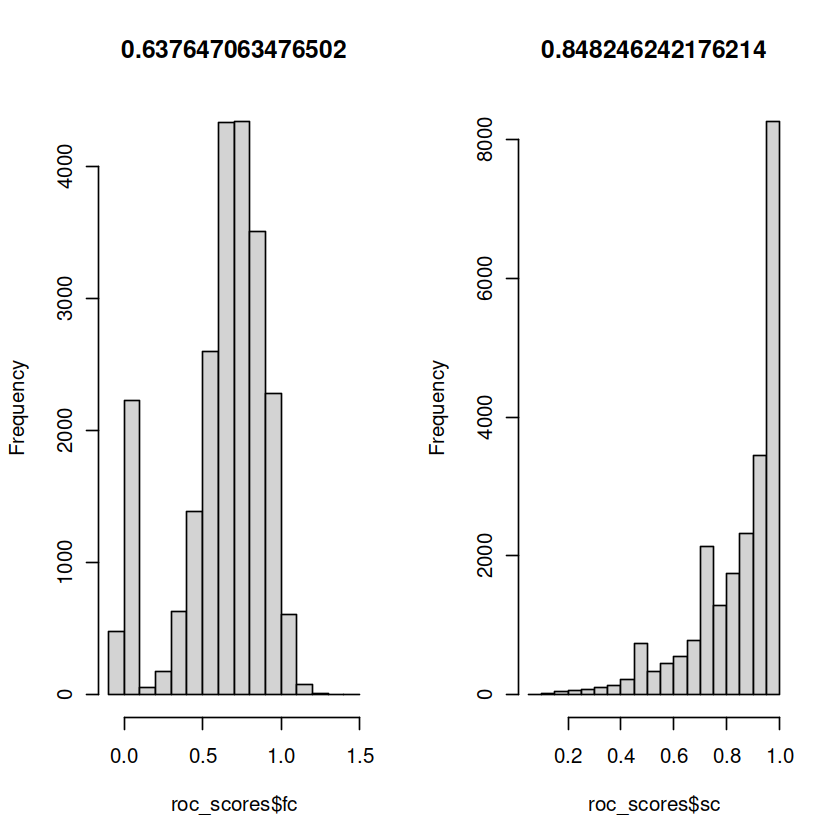

In [10]:
dim(roc_scores)
roc_scores[grep('TBX5', roc_scores[,1]),]

par(mfrow=c(1,2))
hist(roc_scores$fc, main = mean(roc_scores$fc, na.rm = T))
hist(roc_scores$sc, main = mean(roc_scores$sc, na.rm = T))

In [11]:
# plot distributions of scores
library(ggplot2)
library(ggridges)
library(corrplot)
stages = c('stage9', 'stage13', 'stage16')
combos = combn(length(stages),2)
combos

corrplot 0.92 loaded



[,1] [,2] [,3]
[1,] 1    1    2   
[2,] 2    3    3

In [12]:
newdf = c()
corrmat = matrix(NA, nrow = 3, ncol = 3)
for(ii in 1:dim(combos)[2]){
    df1 = read.delim(paste0('lizard_', stages[combos[1,ii]], '_', stages[combos[2,ii]],
                            '_pseudobulk_coexp_cons.csv'), sep = ',')
    df1$stage = paste0(stages[combos[1,ii]], '_', stages[combos[2,ii]])
    corrmat[combos[1,ii], combos[2,ii]] = mean(df1$sc, na.rm = T)
    corrmat[combos[2,ii], combos[1,ii]] = mean(df1$sc, na.rm = T)
    newdf = rbind(newdf, df1)
}
newdf[1,]
rownames(corrmat) = stages
colnames(corrmat) = stages
corrmat

stage1_gene  stage2_gene  fc        sc        stage         
1 LOC132761864 LOC132761864 0.7285151 0.9127014 stage9_stage13

stage9    stage13   stage16  
stage9         NA 0.8534160 0.8526505
stage13 0.8534160        NA 0.8482462
stage16 0.8526505 0.8482462        NA

Loading required package: viridisLite



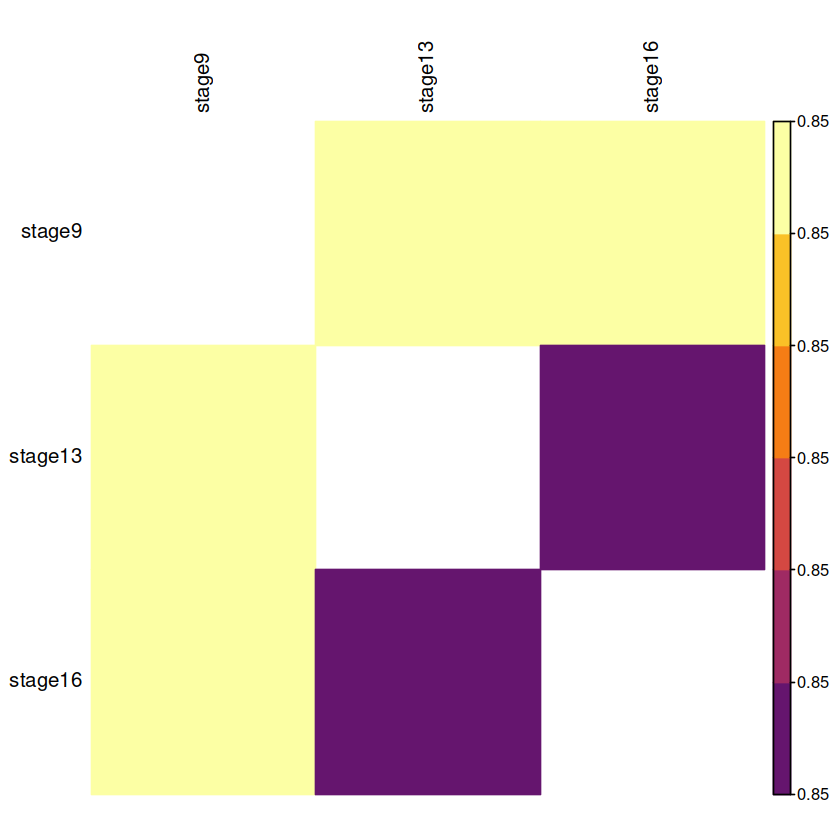

In [13]:
library(viridis)
my_palette = viridis::inferno(8)
# png('aa-human-mouse.png', width = 5, height = 5, res = 300, units = 'in')
# pdf('aa-chicken-3x3.pdf', width = 5, height = 5)
corrplot(corrmat, method = 'color', is.corr = F, col = my_palette[3:8], #col.lim = c(0.7,1),
         tl.col = 'black', na.label = ' ', na.label.col = 'white')
# dev.off()